In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import het_arch

In [38]:
datos_cartera=pd.read_csv('Datos/Transformados/cartera.csv', index_col=[0], parse_dates=[0])
datos_cartera.head()

,AAPL,CAT,MSFT
fecha,,,
2018-06-07,48.37500,156.289993,100.879997
2018-06-08,47.87750,155.320007,101.629997
2018-06-11,47.79000,156.350000,101.050003
2018-06-12,48.08000,157.485000,101.309998
2018-06-13,47.66625,154.700000,100.849998


In [ ]:
# corr_pearson = datos_cartera.corr(method="pearson")

In [ ]:
# fig, ax =plt.subplots(1,1, figsize=(10,10))

# sns.heatmap(corr_pearson, annot=True,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
# ax.set_yticklabels(ax.get_yticklabels(),rotation=0,horizontalalignment='right')
# ax.set_title("Spearman Correlation Matrix");

### AAPL

<AxesSubplot:xlabel='fecha'>

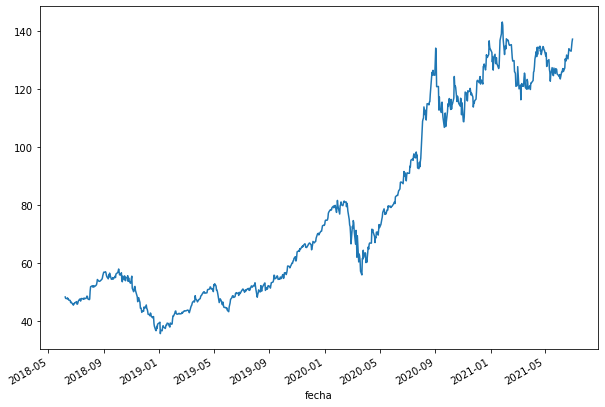

In [39]:
datos_cartera['AAPL'].plot(figsize=(10,7))

In [40]:
datos_cartera['AAPL'].isna().sum()

0

In [41]:
datos_cartera['AAPL'].dtype

dtype('float64')

In [42]:
datos_cartera['AAPL'].resample('Y').count()

fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: A-DEC, Name: AAPL, dtype: int64

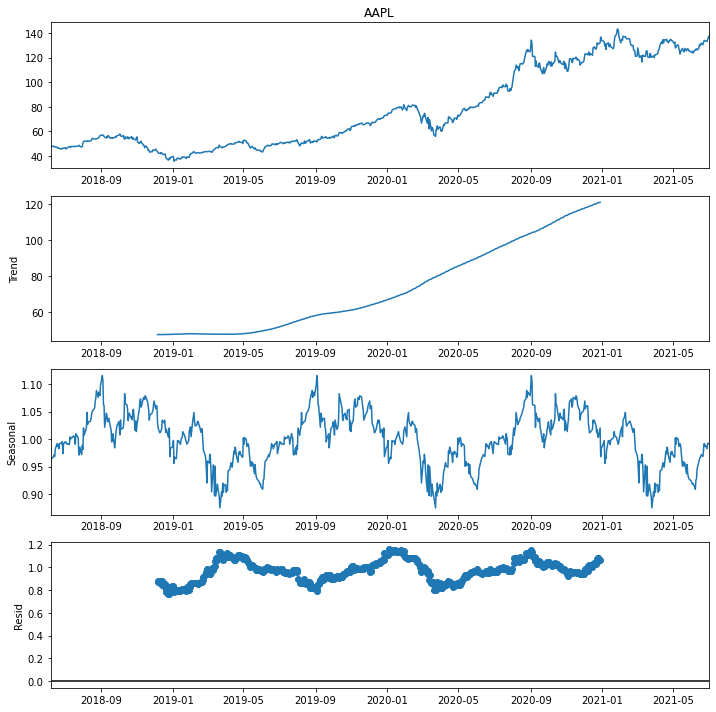

In [43]:
decomposicion_aapl = seasonal_decompose(datos_cartera["AAPL"], model='multiplicativa', period=261)
plt.rcParams['figure.figsize'] = (10, 10)
decomposicion_aapl.plot()
plt.show()

TENDENCIA

<AxesSubplot:xlabel='fecha'>

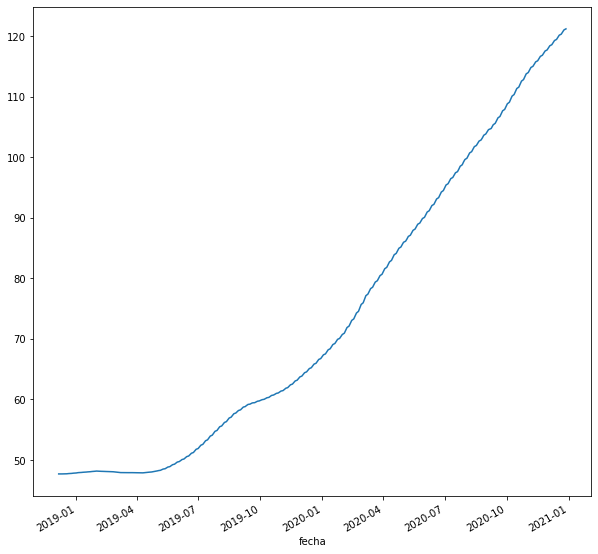

In [44]:
trend=decomposicion_aapl.trend
trend.dropna(inplace=True)
trend.plot()

ESTACIONALIDAD

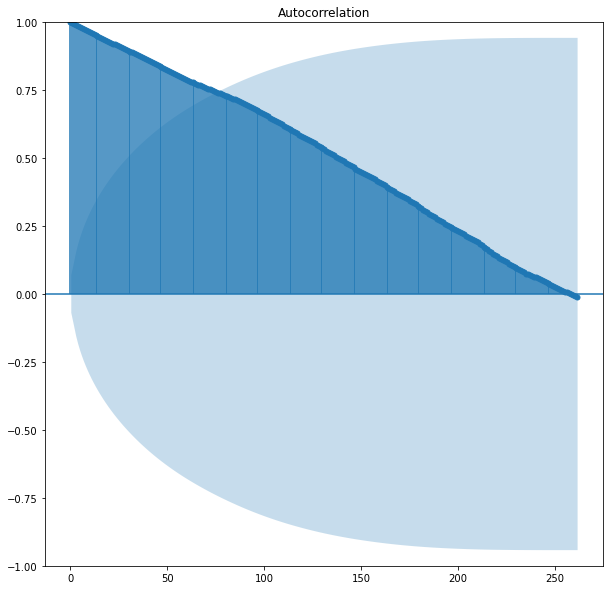

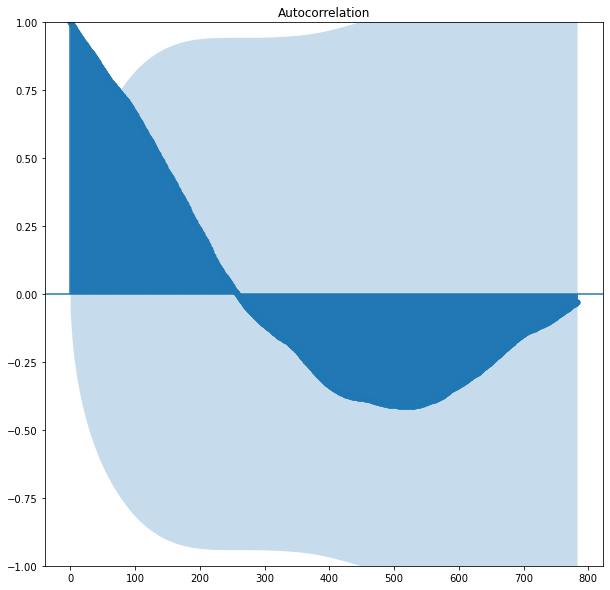

In [51]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['AAPL'], lags=261);
tsaplots.plot_acf(datos_cartera['AAPL'], lags=(261*3));

<AxesSubplot:xlabel='fecha'>

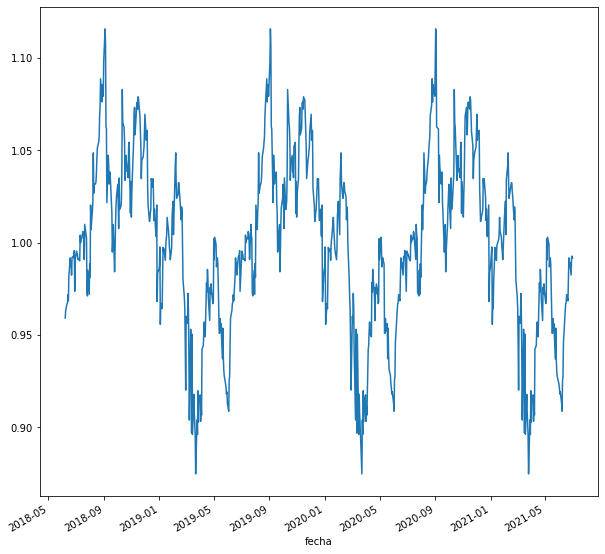

In [53]:
decomposicion_aapl.seasonal.plot()

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

In [56]:
datos_cartera['resido_AAPLE'] = datos_cartera['AAPL'] - trend
datos_cartera['resido_AAPLE'].dropna(inplace=True)
datos_cartera.head()

,AAPL,CAT,MSFT,resido_AAPLE
fecha,,,,
2018-06-07,48.37500,156.289993,100.879997,NaN
2018-06-08,47.87750,155.320007,101.629997,NaN
2018-06-11,47.79000,156.350000,101.050003,NaN
2018-06-12,48.08000,157.485000,101.309998,NaN
2018-06-13,47.66625,154.700000,100.849998,NaN


<AxesSubplot:xlabel='fecha'>

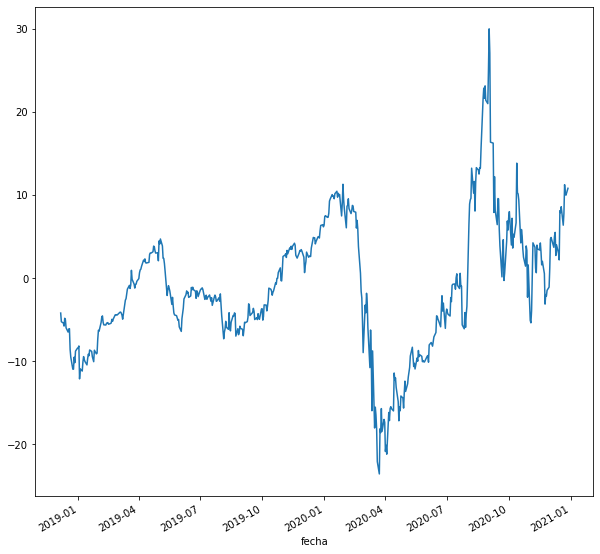

In [57]:
datos_cartera['resido_AAPLE'].plot()

In [65]:
def test_estacionario(residuo):

    residuo=residuo.dropna()
    adf_test = adfuller(residuo, autolag='AIC')
    p_adf = adf_test[1]

    kpss_test = kpss(residuo, nlags="auto")
    p_kpss = kpss_test[1]

    arch_test = het_arch(residuo)
    p_arch = arch_test[1]

    if p_adf < 0.05 and p_kpss > 0.05:
        estacionario = "La serie es ESTACIONARIA"
    else:
        estacionario = "La serie NO es estacionaria"

    if p_arch < 0.05:
        heterocedasticidad = "Existe HETEROCEDASTICIDAD (varianza no constante)"
    else:
        heterocedasticidad = "No hay heterocedasticidad (varianza constante)"

    resultados = {
        'ADF_pvalue': p_adf,
        'KPSS_pvalue': p_kpss,
        'ARCH_pvalue': p_arch,
        'Conclusión_estacionariedad': estacionario,
        'Conclusión_heterocedasticidad': heterocedasticidad
    }
    
    return resultados

In [66]:
test_aapl=test_estacionario(datos_cartera['resido_AAPLE'])
test_aapl

{'ADF_pvalue': 0.22849989581876723,
 'KPSS_pvalue': 0.06546031163641822,
 'ARCH_pvalue': 8.515958552554994e-90,
 'Conclusión_estacionariedad': 'La serie NO es estacionaria',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

### MSFT

<AxesSubplot:xlabel='fecha'>

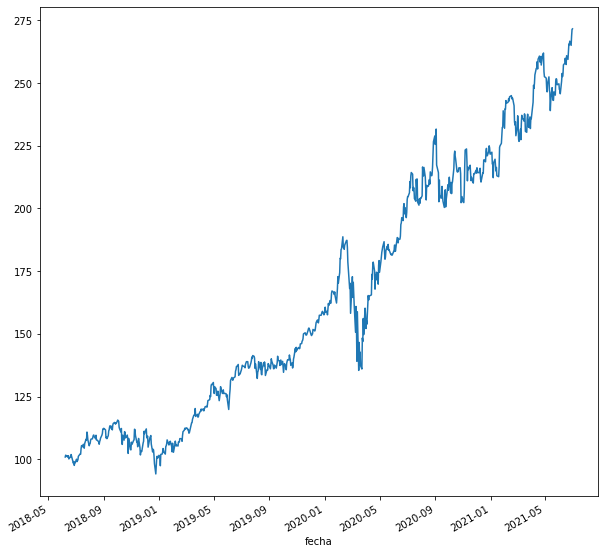

In [67]:
datos_cartera['MSFT'].plot()

In [68]:
datos_cartera['MSFT'].isna().sum()

0

In [69]:
datos_cartera['MSFT'].resample('Y').count()

fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: A-DEC, Name: MSFT, dtype: int64

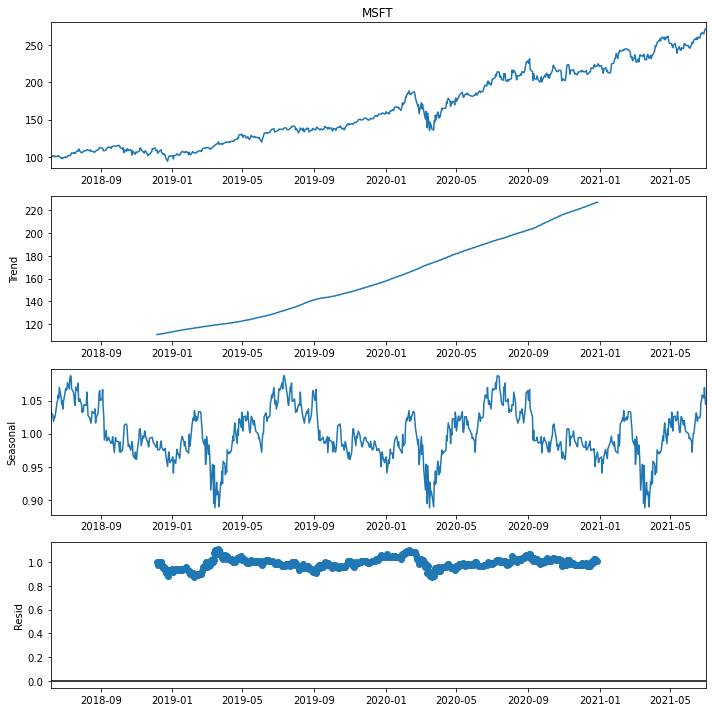

In [72]:
decomposicion_msft = seasonal_decompose(datos_cartera["MSFT"], model='multiplicativa', period=261)
plt.rcParams['figure.figsize'] = (10, 10)
decomposicion_msft.plot()
plt.show()

TENDENCIA

<AxesSubplot:xlabel='fecha'>

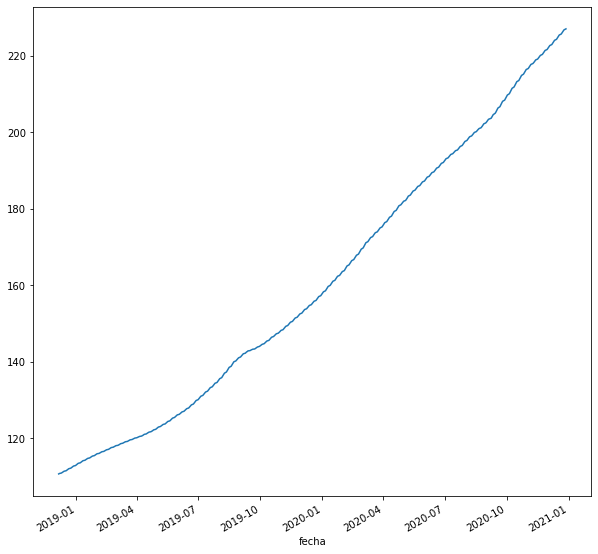

In [73]:
trend_msft=decomposicion_msft.trend
trend_msft.dropna(inplace=True)
trend_msft.plot()

ESTACIONALIDAD

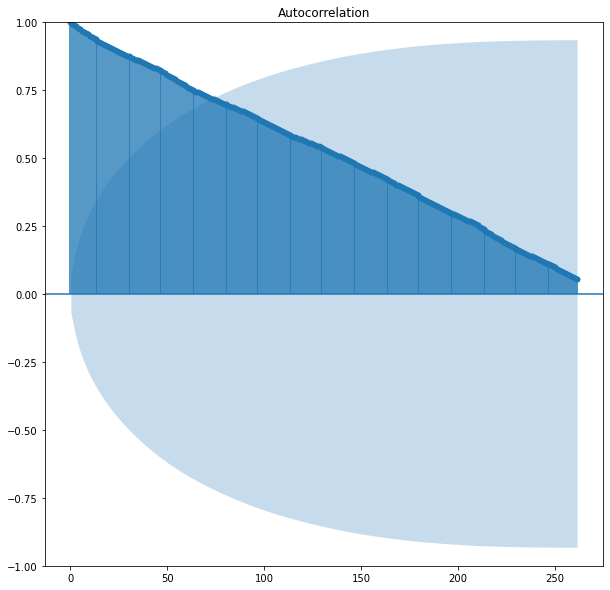

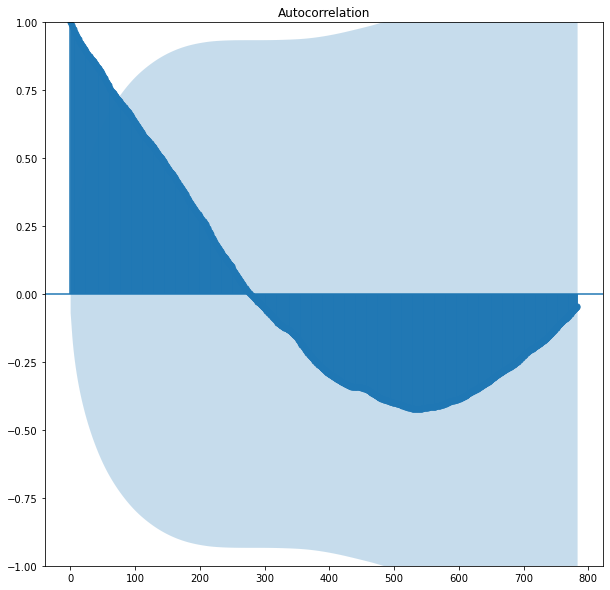

In [74]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['MSFT'], lags=261);
tsaplots.plot_acf(datos_cartera['MSFT'], lags=(261*3));

<AxesSubplot:xlabel='fecha'>

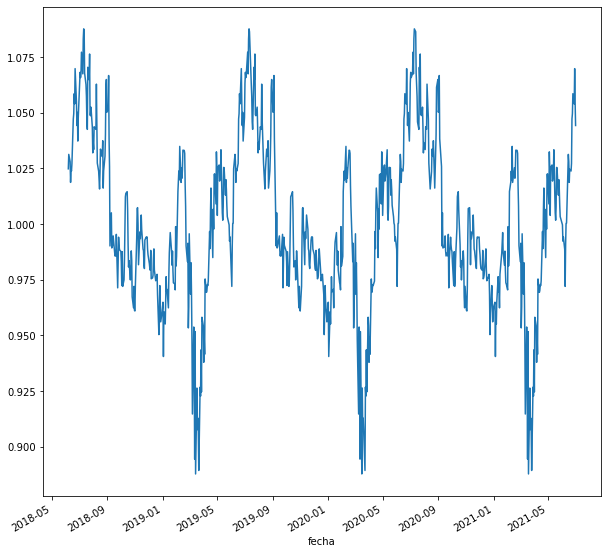

In [75]:
decomposicion_msft.seasonal.plot()

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

In [79]:
datos_cartera['residuo_MSFT'] = datos_cartera['MSFT'] - trend_msft
datos_cartera['residuo_MSFT'].dropna(inplace=True)
datos_cartera.head()

,AAPL,CAT,MSFT,resido_AAPLE,resido_MSFT,residuo_MSFT
fecha,,,,,,
2018-06-07,48.37500,156.289993,100.879997,NaN,NaN,NaN
2018-06-08,47.87750,155.320007,101.629997,NaN,NaN,NaN
2018-06-11,47.79000,156.350000,101.050003,NaN,NaN,NaN
2018-06-12,48.08000,157.485000,101.309998,NaN,NaN,NaN
2018-06-13,47.66625,154.700000,100.849998,NaN,NaN,NaN


<AxesSubplot:xlabel='fecha'>

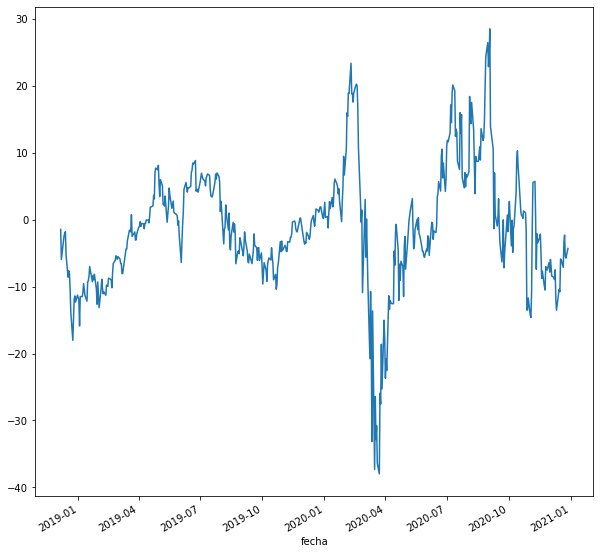

In [80]:
datos_cartera['residuo_MSFT'].plot()

In [81]:
test_msft=test_estacionario(datos_cartera['residuo_MSFT'])
test_msft

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


{'ADF_pvalue': 0.004349738296875109,
 'KPSS_pvalue': 0.1,
 'ARCH_pvalue': 6.428575653903413e-77,
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

GARCH

In [85]:
# Modelo GARCH(1,1)
from arch import arch_model
modelo_garch = arch_model(datos_cartera['resido_MSFT'], vol='GARCH', p=1, q=1, dist='normal')

# Ajustar el modelo
resultado_garch = modelo_garch.fit(update_freq=5, disp='off')

# Resumen
print(resultado_garch.summary())


TypeError: 'numpy._DTypeMeta' object is not subscriptable